# CSE 6040, Fall 2015 [23]: Linear regression via least squares

Last time we motivated the linear regression modeling problem using some data. The next question is, how do you actually compute the model? Rather than relying on a canned library (which is what we recommend you do in practice), the goal of the previous lesson and this one is to give you a glimpse into the inner-workings of these methods, which bring in a lot of subtle (but hopefully also fun and interesting!) numerical computing issues.

To complete today's notebook, you may find these resources helpful:

* SciPy solvers documentation, including linear systems solvers: http://docs.scipy.org/doc/scipy/reference/linalg.html
* A numerical linear algebra textbook by [Demmel](http://epubs.siam.org/doi/book/10.1137/1.9781611971446)

## Review: Computing a sum

Let $p$ be a vector (array) of length $n$. Suppose we wish to sum its values. Mathematically, denote the exact sum by,

  $$s_{n-1} = \sum_{i=0}^{n-1} p_i = p_0 + p_1 + p_2 + \cdots + p_{n-1}.$$
  
Now consider the following Python program to compute its sum:

In [1]:
def alg_sum (p): # p = p[0:n]
    s = 0.
    for p_i in p:
        s = s + p_i
    return s

Last time, we analyzed the propagation of errors in this algorithm. Let $\hat{s}_i$ be the partial sum computed by the algorithm at the beginning of iteration $i$ (instance of `p_i`). We set up and solved the recurrence,

$$
\begin{array}{rcl}
      \hat{s}_0 & = & 0 \\
  \hat{s}_{i+1} & = & (\hat{s}_i + p_i)(1 + \delta_i)
\end{array}
$$

where $\delta_i$ is the round-off error incurred at iteration $i$. Our goal is to determine $\hat{s}_n$, which is the final value of the computed sum.

The approximate solution to this recurrence was,

$$
\begin{array}{rcl}
  \hat{s}_n \approx \sum_{i=0}^{n-1} p_i \cdot \left(1 + \Delta_i\right),
\end{array}
$$

where

$$
\begin{array}{rcl}
  \Delta_i \equiv \sum_{j=0}^i \delta_i.
\end{array}
$$

The approximation comes from the fact that we dropped terms that included products $\delta_i \delta_j$ as small.

Lastly, from the bound that all $|\delta_i| \leq \epsilon$, we showed that

$$
\begin{array}{rcl}
  \left| \Delta_i \right|
    & \leq & (i+1) \cdot \epsilon.
\end{array}
$$

One application of these calculations was to compute a bound on both the absolute and relative errors of this summation algorithm. The absolute error is,

$$
\begin{array}{rcl}
  \left|\hat{s}_{n-1} - s_{n-1}\right|
    & \lesssim & n \cdot \epsilon \cdot \|p\|_1,
\end{array}
$$

and the relative error is,

$$
  \frac{\left|\hat{s}_n - s_{n-1}\right|}
       {\left|s_{n-1}\right|}
    \lesssim n \cdot \epsilon \cdot \frac{\|p\|_1}
                                         {\left|s_{n-1}\right|}
        =    n \cdot \epsilon \cdot \sum_{i=0}^{n-1} \left| \frac{p_i}
                                                                 {s_{n-1}}
                                                      \right|
  .
$$

While this bound can be small, it can also be quite conservative. (Why?)

Another application of the above result was an analysis of a particular algorithm to compute the dot product of two vectors, $x$ and $y$, which mathematically is $f(x, y) \equiv x^T y$.

In [2]:
def alg_dot (x, y):
    p = [xi*yi for (xi, yi) in zip (x, y)]
    s = alg_sum (p)
    return s

We derived absolute and relative error bounds for `alg_dot()`, summarized below, and furthermore argued that it is backward stable.

Let $\hat{p}_i$ denote the error in the $i$-th product, i.e.,

   $$\hat{p}_i = x_i y_i \left(1 + \gamma_i\right).$$

One can show the absolute error is, approximately,

$$
\begin{array}{rcl}
  \left| \hat{s}_{n-1} - \sum_i x_i y_i \right|
    & \approx & \left| \sum_i x_i y_i (\gamma_i + \Delta_i) \right| \\
    &   \leq  & \sum_i \left| x_i \right| \cdot \left| y_i \right|
                       \cdot \left( \left| \gamma_i \right| + \left| \Delta_i \right| \right) \\
    &   \leq  & (n+1) \cdot \epsilon \cdot |x|^T |y|,
\end{array}
$$

where $|x|$ and $|y|$ refer to componentwise absolute values. The relative error bounds follow from dividing both sides by the absolute value of the exact dot product:

$$
\begin{array}{rcl}
  \frac{\left| \hat{s}_{n-1} - x^T y \right|}
       {\left| x^T y \right|}
    & \approx & (n+1) \epsilon \frac{|x|^T |y|}{|x^T y|}.
\end{array}
$$

## Review: Perturbation theory for solving linear systems

Having taken that detour, we can now return to our original motivating problem: solving an overdetermined system of linear equations, $Ax=b$ where the real-valued $m \times n$ matrix $A \in \mathbb{R}^{m \times n}$ has at least as many rows as columns ($m \geq n$). Let's further assume that $A$ has full rank ($\mathrm{rank}(A) = n$), i.e., the columns of $A$ are linearly independent.

Since the system is overdetermined, it will not have a unique solution. Therefore, we will need to compute a "best fit" approximate solution. We will look at a couple different algorithms for solving this system. Then, using the analysis techniques mentioned above, see how we might determine what method we should use.

You will need several facts from linear algebra, some of which appear as exercises, like this one:

**Exercise.** Let $x \in \mathbb{R}^n$ be a real-valued vector of length $n$. Show that $\|x\|_2^2 = x^T x$.

> _@YOUSE: Enter your answer(s) here._

Observe that the vector two-norm, $\|\cdot\|_2$, gives you a way to measure the "length" of a vector.

**Exercise.** Given two vectors, $x$ and $y$, show that the dot product is commutative, i.e., $x^T y = y^T x$.

> _@YOUSE: Enter your answer here._

Let's start by asking how "hard" it is to solve a given linear system, $Ax=b$. You will apply perturbation theory to answer this question.

First, some notation. To measure the magnitudes of the perturbations, we will use vector and matrix norms. Assume that the norm of a vector, $\|x\|_2$, denotes the vector 2-norm; further assume that the norm of a matrix, $\|A\|_F$, denotes the matrix Frobenius norm. If you need a refesher on these definitions, see our [linear algebra notes](https://t-square.gatech.edu/access/content/group/gtc-7308-4387-56aa-b79e-a3f4c812167d/Kuang-2014-linalg-notes.pdf). The most important identities for the discussion below are:

* _Triangle inequality_: $\|x + y\|_2 \leq \|x\|_2 + \|y\|_2$
* _Norm of a matrix-vector product_: $\|Ax\|_2 \leq \|A\|_F\cdot\|x\|_2$
* _Norm of matrix-matrix product_: $\|AB\|_F \leq \|A\|_F\cdot\|B\|_F$

To simplify the notation a little, we will drop the "$2$" and "$F$" subscripts.

Next, suppose all of $A$, $b$, and the eventual solution $x$ undergo additive perturbations, denoted by $A + \Delta A$, $b + \Delta b$, and $x + \Delta x$, respectively. Then, subtracting the original system from the perturbed system, you would obtain the following.

$$
\begin{array}{rrcll}
   &         (A + \Delta A)(x + \Delta x) & = & b + \Delta b & \\
- [&                                   Ax & = & b & ] \\
\hline
   & \Delta A x + (A + \Delta A) \Delta x & = & \Delta b & \\
\end{array}
$$

Now look more closely at the perturbation, $\Delta x$, of the solution. Let $\hat{x} \equiv x + \Delta x$ be the perturbed solution. Then the above can be rewritten as,

$$\Delta x = A^{-1} \left(\Delta b - \Delta A \hat{x}\right),$$

where we have assumed that $A$ is invertible. (That won't be true for our overdetermined system, but let's not worry about that for the moment.)

How large is $\Delta x$? Let's use a norm to measure it and bound it using 

$$
\begin{array}{rcl}
  \|\Delta x\| &   =   & \|A^{-1} \left(\Delta b - \Delta A \hat{x}\right)\| \\
               &  \leq & \|A^{-1}\|\cdot\left(\|\Delta b\| + \|\Delta A\|\cdot\|\hat{x}\|\right).
\end{array}
$$

You can rewrite this as follows:

$$
\begin{array}{rcl}
  \frac{\|\Delta x\|}
       {\|\hat{x}\|}
    & \leq &
    \|A^{-1}\| \cdot \|A\| \cdot \left(
                                   \frac{\|\Delta A\|}
                                        {\|A\|}
                                   +
                                   \frac{\Delta b}
                                        {\|A\| \cdot \|\hat{x}\|}
                                 \right).
\end{array}
$$

This bound says that the relative error of the perturbed solution, compared to relative perturbations in $A$ and $b$, scales with the product, $\|A^{-1}\| \cdot \|A\|$. This factor is the linear systems analogue of the condition number for evaluating the function $f(x)$! As such, we define

$$\kappa(A) \equiv \|A^{-1}\| \cdot \|A\|$$

as the _condition number of $A$_ for solving linear systems.

## Review: A numerical example of an ill-conditioned linear system

Let's look at a system that is ill-conditioned and see what happens when we make a tiny perturbation to it.

In [3]:
import numpy as np

In [4]:
A = np.array([(1., 1000.),
              (2.**(-10) + 2.**(-11), 1.)])

print "A ==\n", A
print "\ncond (A) == ", np.linalg.cond (A)

A ==
[[  1.00000000e+00   1.00000000e+03]
 [  1.46484375e-03   1.00000000e+00]]

cond (A) ==  2151264.80673


In [5]:
Delta_A = np.array ([(0., 0.),
                     (-2.**(-11), 0.)
                    ])
B = A + Delta_A

print "B := A + dA ==\n", B
print "\ncond (B) / cond (A) == ", \
      np.linalg.cond (B) / np.linalg.cond (A)

B := A + dA ==
[[  1.00000000e+00   1.00000000e+03]
 [  9.76562500e-04   1.00000000e+00]]

cond (B) / cond (A) ==  19.8333333333


In [6]:
b = np.array([1., 1.])

x_A = np.linalg.solve (A, b)
print "x ~= A^(-1)*b == ", x_A

x_B = np.linalg.solve (B, b)
print "x ~= B^(-1)*b == ", x_B

x ~= A^(-1)*b ==  [  2.14910924e+03  -2.14810924e+00]
x ~= B^(-1)*b ==  [-42624.        42.625]


## Solving overdetermined systems: Least squares minimization

If $Ax=b$ is overdetermined, then there are more equations (rows of $Ax$) than unknowns (entries of $x$) and no solution in general. Therefore, we ask for an approximate solution $x$. How do we choose $x$?

One intuitive idea is to choose an $x$ such that the _residual_, $r = r(x) \equiv b - Ax$, is minimized in some way, such as measuring the length of $r$ using the vector two-norm:

$$
\begin{array}{rcl}
  \arg\!\min_{x} \|r(x)\|_2^2
    & = & \arg\!\min_{x} \|b - Ax\|_2^2 \\
    & = & \arg\!\min_{x} (b - Ax)^T(b - Ax) \\
    & = & \arg\!\min_{x} \left\{ b^T b - 2 x^T A^T b + x^T A^T A x \right\}.
\end{array}
$$

**Gradients.** To find the minimum $x$, we need to do the moral equivalent of taking a "vector derivative," setting it to 0, and then solving for $x$. The right mathematical tool is the _gradient_. Given a _scalar_ function $f(x)$, where $x$ is a vector, the function's gradient, $\nabla_x f(x)$, is a _vector_ whose $k$-th entry is the partial derivative of $f(x)$ with respect to $x_k$. That is,

$$
\nabla_x f(x) \equiv
  \left(\begin{array}{c}
    \frac{\partial f}{\partial x_0} \\
    \frac{\partial f}{\partial x_1} \\
    \vdots \\
    \frac{\partial f}{\partial x_{n-1}}
  \end{array}\right).
$$

**Exercise.** Let $x$ and $y$ be vectors, and let $M$ be a matrix. Verify the following identities related to the gradient.

1. $\nabla_x (x^T y) = y$
2. $\nabla_x (x^T x) = 2x$
3. $\nabla_x (x^T M x) = (M + M^T)x$

> _@YOUSE_: Enter your answer(s) here.

**Exercise.** Let $f(x) \equiv (b - Ax)^T(b - Ax)$, where $x \in \mathbb{R}^n$, $b \in \mathbb{R}^m$, and $A \in \mathbb{R}^{m \times n}$. Show that

$$\nabla_x f(x) = 2 (A^T A x - A^T b).$$

> _@YOUSE_: Enter your answer(s) here.

**Normal equations.** In the previous exercise, $f(x)$ is precisely the objective function we wish to minimize by a suitable choice of $x$. The minimum occurs when $\nabla_x f(x) = 0$; per the execises above, this $x$ is the solution to the _normal equations_,

$$A^T A x = A^T b.$$

**Exercise.** You could solve this system directly, by first forming $C \leftarrow A^TA$ and $c \leftarrow A^T b$, and then solving $Cx=c$. But is this a good algorithm? (You may assume $C$ is invertible.) Why or why not?

> _@YOUSE_: Enter your answer here.

**QR factorization.** In fact, the standard method to solve the linear least squares problem is to use a so-called QR factorization.

As it happens, every full-rank matrix $A \in \mathbb{R}^{m \times n}$, with $m \geq n$, may be written as the product $A = QR$, where $Q$ is an $m \times n$ orthogonal matrix (i.e., $Q^T Q = I_n$, the $n \times n$ diagonal matrix of all ones) and $R$ is an $n \times n$ upper-triangular with positive diagonals ($r_{ii} > 0$).

**Exercise.** Suppose you are given a QR decomposition, $A = QR$. Show how to compute the solution $x$ of the linear least squares problem.

> _@YOUSE_: Enter your answer here.

Solving the normal equations is generally cheaper than performing a QR factorization. However, using QR is more numerically accurate. Algorithms to compute a QR factorization are numerically stable, and solving the system using QR has a lower condition number than solving by using the normal equations. Additionally, applying (multiplying by) an orthogonal matrix is a stable operation.

## Some numerical examples

#### Example: A poorly conditioned system

Consider the following sequence of code cells.

In [7]:
# This file implements the experiment in Lecture 19 of
# Trefethen and Bau, Numerical Linear Algebra, SIAM 1997.
#
# Python implementation originally by Da Kuang (2014)

import scipy.linalg as lin
import matplotlib.pyplot as plt
%matplotlib inline

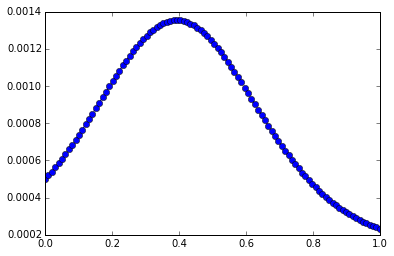

In [15]:
m = 100

t = np.arange (0, m, dtype=np.float64)
t /= (m-1)

b = np.exp (np.sin (4*t))
b /= 2006.787453080206

plt.plot (t, b, 'o--')

In [9]:
n = 15
A = np.zeros ((m, n))

for i in range (n):
    A[:, i] = np.power (t, i)
    
print 'Condition number of A: %g' % np.linalg.cond (A)

Condition number of A: 2.27178e+10


**Exercise.** The preceding code sets up a linear system, $Ax=b$, to solve. What does solving it correspond to?

> _@YOUSE: Enter your explanation here._

Let's consider solving this system in 3 ways: using SciPy's built-in linear least squares solver, explicit QR factorization, and by solving the normal equations. What do you observe?

In [10]:
result = np.linalg.lstsq (A, b)
x1 = result[0]
print 'Last element of x1 (possibly from SVD):', x1[-1]
print 'Two-norm of the residual:', np.linalg.norm (b - A.dot (x1), ord=2)
print 'Infinity-norm of the residual:', np.linalg.norm (b - A.dot (x1), ord=np.inf)

Last element of x1 (possibly from SVD): 1.00000008671
Two-norm of the residual: 3.43674914278e-08
Infinity-norm of the residual: 9.01280801716e-09


In [11]:
Q, R = np.linalg.qr (A)
tmp = Q.T.dot (b)
x2 = np.linalg.solve (R, tmp)
print 'Last element of x2 (from QR):', x2[-1]
print 'Two-norm of the residual:', np.linalg.norm (b - A.dot (x2), ord=2)
print 'Infinity-norm of the residual:', np.linalg.norm (b - A.dot (x2), ord=np.inf)

Last element of x2 (from QR): 1.0000000867
Two-norm of the residual: 3.43674902109e-08
Infinity-norm of the residual: 9.01279996295e-09


In [12]:
ATA = A.T.dot (A)
tmp = A.T.dot (b)
x3 = np.linalg.solve (ATA, tmp)
print 'Last element of x3 (from normal equation):', x3[-1]
print 'Two-norm of the residual:', np.linalg.norm (b - A.dot (x3), ord=2)
print 'Infinity-norm of the residual:', np.linalg.norm (b - A.dot (x3), ord=np.inf)

try:
    L = np.linalg.cholesky (ATA)
except np.linalg.linalg.LinAlgError, e:
    print 'Cholesky factorization error:', e

print 'Condition number of A\'A:', np.linalg.cond (ATA)

Last element of x3 (from normal equation): -0.0955609462272
Two-norm of the residual: 2.31641736661e-07
Infinity-norm of the residual: 4.45509421648e-08
Cholesky factorization error: Matrix is not positive definite
Condition number of A'A: 2.19142928688e+18


#### Example: Nearly collinear predictors

Another practical situation in which poor conditioning can arise in linear regression modeling is when you include two strongly correlated predictors.

In [13]:
tmp = np.arange (100)
A = np.zeros ((100, 2))

delta_0 = np.random.rand (100) * 0.0001
delta_1 = np.random.rand (100) * 0.0001

A[:, 0] = tmp + delta_0
A[:, 1] = tmp + delta_1

ATA = A.T.dot(A)

print 'cond (A):', np.linalg.cond (A)
print 'cond (A^T*A):', np.linalg.cond (ATA)

cond (A): 2661003.12291
cond (A^T*A): 7.07569987721e+12
